In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np


import tqdm

In [2]:
learning_rate = 0.01
training_epochs = 10001
display_step = 500

d = 0.1

In [3]:
x, y = np.arange(0, 1 + d / 2, d)[:, None], np.arange(0, 1 + d / 2, d)[:, None]
X, Y = np.meshgrid(x, y)

grid = np.concatenate((Y.reshape(-1, 1), X.reshape(-1, 1)), axis=1)
n = x.shape[0]

In [4]:
x_0 = grid[:n]
x_1 = grid[-n:]
y_0 = grid[::n]
y_1 = grid[n - 1::n]

In [5]:
n_hidden_1 = 64
n_hidden_2 = 64
n_hidden_3 = 64
n_input = 2
n_classes = 2

In [8]:
X = tf.placeholder("double", [None, n_input])

X_0 = tf.placeholder("double", [None, n_input])
X_1 = tf.placeholder("double", [None, n_input])
Y_0 = tf.placeholder("double", [None, n_input])
Y_1 = tf.placeholder("double", [None, n_input])

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], dtype=tf.double)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], dtype=tf.double)),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], dtype=tf.double)),
    'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_3], dtype=tf.double)),
    'h5': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_3], dtype=tf.double)),
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes], dtype=tf.double))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], dtype=tf.double)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2], dtype=tf.double)),
    'b3': tf.Variable(tf.random_normal([n_hidden_3], dtype=tf.double)),
    'b4': tf.Variable(tf.random_normal([n_hidden_3], dtype=tf.double)),
    'b5': tf.Variable(tf.random_normal([n_hidden_3], dtype=tf.double)),
    'out': tf.Variable(tf.random_normal([n_classes], dtype=tf.double))
}

In [9]:
def multilayer_perceptron(x):
    layer_1   = tf.nn.tanh(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    layer_2   = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    layer_3   = tf.nn.tanh(tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']))
    layer_4   = tf.nn.tanh(tf.add(tf.matmul(layer_3, weights['h4']), biases['b4']))
    out_layer = tf.matmul(layer_4, weights['out']) + biases['out']
    return out_layer

In [10]:
U = multilayer_perceptron(X)

U_X_0 = multilayer_perceptron(X_0)
U_X_1 = multilayer_perceptron(X_1)
U_Y_0 = multilayer_perceptron(Y_0)
U_Y_1 = multilayer_perceptron(Y_1)

In [11]:
(du_dx, du_dy) = tf.split(tf.gradients(U[:, 0][:, None], X)[0], [1, 1], 1)
(dv_dx, dv_dy) = tf.split(tf.gradients(U[:, 1][:, None], X)[0], [1, 1], 1)

(d2u_dx2, d2u_dydx) = tf.split(tf.gradients(du_dx, X)[0],  [1, 1], 1)
(d2u_dxdy, d2u_dy2) = tf.split(tf.gradients(du_dy, X)[0],  [1, 1], 1)

(d2v_dx2,  d2v_dydx) = tf.split(tf.gradients(dv_dx, X)[0], [1, 1], 1)
(d2v_dxdy, d2v_dy2)  = tf.split(tf.gradients(dv_dy, X)[0], [1, 1], 1)

In [12]:
E, nu = 1.0, 0.25
mu    = E / (2 + 2 * nu)
lamb  = (E * nu) / ((1 + nu) * (1 - 2 * nu))

In [13]:
eq1 = tf.reduce_mean(tf.pow(du_dx + du_dy - 2, 2))
eq2 = tf.reduce_mean(tf.pow(du_dy + du_dx - 0, 2))

loss_U = eq1 + eq2

loss_X_0 = tf.norm(U_X_0[:, 0] - X_0[:, 0] - X_0[:, 1]) + tf.norm(U_X_0[:, 0] - X_0[:, 0] + X_0[:, 1])
loss_X_1 = tf.norm(U_X_1[:, 0] - X_1[:, 0] - X_1[:, 1]) + tf.norm(U_X_1[:, 0] - X_1[:, 0] + X_1[:, 1])
loss_Y_0 = tf.norm(U_Y_0[:, 0] - Y_0[:, 0] - Y_0[:, 1]) + tf.norm(U_Y_0[:, 0] - Y_0[:, 0] + Y_0[:, 1])
loss_Y_1 = tf.norm(U_Y_1[:, 0] - Y_1[:, 0] - Y_1[:, 1]) + tf.norm(U_Y_1[:, 0] - Y_1[:, 0] + Y_1[:, 1])

loss = loss_U + loss_X_0 + loss_X_1 + loss_Y_0 + loss_Y_1

In [14]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
train_errors = []
y, err = None, None

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):

    _, err = sess.run([train_op, loss], feed_dict={
        X: grid,
        X_0: x_0,
        X_1: x_1,
        Y_0: y_0,
        Y_1: y_1,
    })

    train_errors += [err]
    
    if np.log10(train_errors[-1]) < -11.0:
        break
    
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch + 1), "cost={:.9f}".format(np.log10(train_errors[-1])))
print("Optimization Finished!")

Epoch: 0001 cost=4.159348274
Epoch: 0501 cost=1.356184915
Epoch: 1001 cost=1.236677250
Epoch: 1501 cost=1.225158611
Epoch: 2001 cost=1.221860750
Epoch: 2501 cost=1.220541689
Epoch: 3001 cost=1.221093213
Epoch: 3501 cost=1.221518106
Epoch: 4001 cost=1.221956014
Epoch: 4501 cost=1.222273669
Epoch: 5001 cost=1.222407340
Epoch: 5501 cost=1.223391629
Epoch: 6001 cost=1.223436112
Epoch: 6501 cost=1.225045543
Epoch: 7001 cost=1.224066164
Epoch: 7501 cost=1.224313296
Epoch: 8001 cost=1.223793749
Epoch: 8501 cost=1.224444862
Epoch: 9001 cost=1.224458192
Epoch: 9501 cost=1.224914359
Epoch: 10001 cost=1.224437156
Optimization Finished!


In [ ]:
[u, err, _du_dx, _du_dy] = sess.run([U, loss, du_dx, du_dy], feed_dict={
    X: grid,
    X_0: x_0,
    X_1: x_1,
    Y_0: y_0,
    Y_1: y_1
})

In [15]:
u_x, u_y = u[:, 0][:, None], u[:, 1][:, None]

In [16]:
import matplotlib.pyplot as plt

In [17]:
x, y = np.arange(0, 1 + d / 2, d)[:, None], np.arange(0, 1 + d / 2, d)[:, None]
X, Y = np.meshgrid(x, y)

grid = np.concatenate((Y.reshape(-1, 1), X.reshape(-1, 1)), axis=1)
n = x.shape[0]

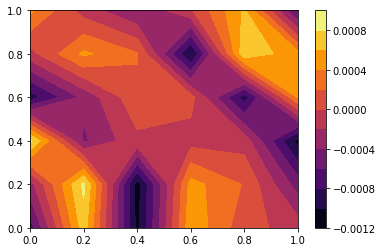

In [19]:
plt.contourf(X, Y, u_x.reshape(X.shape), 10, cmap='inferno')
plt.colorbar()
plt.show()

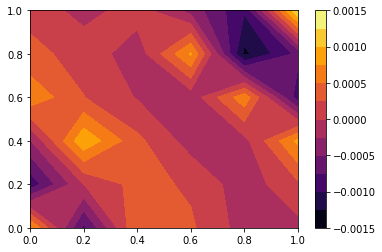

In [21]:
plt.contourf(X, Y, u_y.reshape(X.shape), 10, cmap='inferno')
plt.colorbar()
plt.show()

In [16]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

import deepxde as dde

ModuleNotFoundError: No module named 'deepxde'